# CKD Risk Prediction — Training 

This notebook trains and compares baseline ML models using:

- **13-feature set**: `hemo, sg, rbc, al, htn, pot, dm, pcv, sc, rbcc, sod, age, bp`
- **Final 6-feature set**: `hemo, sc, al, htn, age, dm`

It reuses the project's leakage-safe preprocessing logic:

- Train-only learned **feature-wise regression imputation** (`src.cleaning.model_based_impute`)
- **Clinical bounds** clipping (`src.cleaning.apply_clinical_bounds`)

Metrics reported: ROC-AUC, Precision, Recall, F1.


In [1]:
from __future__ import annotations

import os
import sys
from pathlib import Path

import joblib
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


def _find_project_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'src').exists():
            return p
    return start


PROJECT_ROOT = _find_project_root(Path.cwd().resolve())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Ensure relative paths (dataset/, data/, results/, models/) work reliably
os.chdir(PROJECT_ROOT)

from src.cleaning import apply_clinical_bounds, model_based_impute  # noqa: E402
from src.config import CAT_COLS, CONT_COLS, ORD_COLS, PREPROC_DIR, SPLIT_DIR, RESULTS_DIR  # noqa: E402
from src.utils import ensure_dir, save_json  # noqa: E402

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

RANDOM_STATE = 0
print('PROJECT_ROOT =', PROJECT_ROOT)
print('CWD          =', Path.cwd())


PROJECT_ROOT = E:\docs\FYP\demo\CKD_Risk_Prediction
CWD          = E:\docs\FYP\demo\CKD_Risk_Prediction


## 1) Load cleaned/split datasets (raw + preprocessed)

This notebook expects you have already run the cleaning step:

- `python src/cleaning.py`

That should create:
- `data/processed/splits/X_train_raw.csv`, `X_test_raw.csv`, `y_train.csv`, `y_test.csv`
- `data/processed/preprocessed/X_train_preproc.csv`, `X_test_preproc.csv` (optional sanity check)


In [2]:
import subprocess

split_dir = Path(SPLIT_DIR)

required = [
    split_dir / 'X_train_raw.csv',
    split_dir / 'X_test_raw.csv',
    split_dir / 'y_train.csv',
    split_dir / 'y_test.csv',
]
missing = [p for p in required if not p.exists()]

if missing:
    print('Split files not found. Running cleaning step to regenerate them...')
    cmd = [sys.executable, str(PROJECT_ROOT / 'src' / 'cleaning.py')]
    proc = subprocess.run(cmd, cwd=str(PROJECT_ROOT), capture_output=True, text=True)
    print('cleaning.py return code:', proc.returncode)
    if proc.stdout:
        print('--- cleaning.py stdout ---')
        print(proc.stdout)
    if proc.stderr:
        print('--- cleaning.py stderr ---')
        print(proc.stderr)
    if proc.returncode != 0:
        raise RuntimeError('cleaning.py failed. See stdout/stderr above.')

missing = [p for p in required if not p.exists()]
if missing:
    raise FileNotFoundError(
        'Missing cleaned/split files even after running cleaning.\n\nMissing:\n'
        + '\n'.join(str(p) for p in missing)
    )

X_train_raw = pd.read_csv(split_dir / 'X_train_raw.csv')
X_test_raw = pd.read_csv(split_dir / 'X_test_raw.csv')
y_train = pd.read_csv(split_dir / 'y_train.csv')['target'].to_numpy()
y_test = pd.read_csv(split_dir / 'y_test.csv')['target'].to_numpy()

print('Raw train shape:', X_train_raw.shape)
print('Raw test shape :', X_test_raw.shape)
print('Train positive rate:', float(np.mean(y_train)))
print('Test  positive rate:', float(np.mean(y_test)))

print('\nMissingness (train, top 15):')
miss = X_train_raw.isna().mean().sort_values(ascending=False)
display(miss.head(15))

# Optional sanity-check: preprocessed matrices exist
preproc_dir = Path(PREPROC_DIR)
if (preproc_dir / 'X_train_preproc.csv').exists():
    X_train_preproc = pd.read_csv(preproc_dir / 'X_train_preproc.csv')
    X_test_preproc = pd.read_csv(preproc_dir / 'X_test_preproc.csv')
    print('\nPreprocessed train shape:', X_train_preproc.shape)
    print('Preprocessed test shape :', X_test_preproc.shape)


Raw train shape: (280, 24)
Raw test shape : (120, 24)
Train positive rate: 0.625
Test  positive rate: 0.625

Missingness (train, top 15):


rbc     0.389286
rc      0.310714
wc      0.246429
pot     0.239286
sod     0.235714
pc      0.167857
pcv     0.167857
su      0.139286
sg      0.135714
al      0.132143
hemo    0.125000
bgr     0.114286
bu      0.064286
sc      0.053571
bp      0.028571
dtype: float64


Preprocessed train shape: (280, 34)
Preprocessed test shape : (120, 34)


## 2) Define the two feature sets (13-feature and final-6)

We validate that all requested features exist in the raw split columns.

In [3]:
# Requested feature sets (as provided)
FEAT_13_RAW = ['hemo','sg','rbc','al','htn','pot','dm','pcv','sc','rbcc','sod','age','bp']
FEAT_6_RAW = ['hemo','sc','al','htn','age','dm']

# Common alias fixes (dataset often uses 'rc' for RBC count)
ALIASES = {
    'rbcc': 'rc',
}


def resolve_features(features: list[str], available_cols: set[str]) -> tuple[list[str], list[str]]:
    resolved: list[str] = []
    missing: list[str] = []
    for f in features:
        if f in available_cols:
            resolved.append(f)
        elif f in ALIASES and ALIASES[f] in available_cols:
            resolved.append(ALIASES[f])
        else:
            missing.append(f)
    return resolved, missing


assert len(FEAT_13_RAW) == len(set(FEAT_13_RAW)), 'Duplicates found in 13-feature list'
assert len(FEAT_6_RAW) == len(set(FEAT_6_RAW)), 'Duplicates found in 6-feature list'

available = set(X_train_raw.columns)
FEAT_13, missing_13 = resolve_features(FEAT_13_RAW, available)
FEAT_6, missing_6 = resolve_features(FEAT_6_RAW, available)

print('Resolved 13-feature set:', FEAT_13)
print('Resolved 6-feature set :', FEAT_6)
print('Missing from 13-feature set:', missing_13)
print('Missing from 6-feature set :', missing_6)

if missing_13 or missing_6:
    raise ValueError('Some requested features are not present (even after alias mapping). Check column names in your cleaned dataset.')

print('OK: all requested features resolved.')


Resolved 13-feature set: ['hemo', 'sg', 'rbc', 'al', 'htn', 'pot', 'dm', 'pcv', 'sc', 'rc', 'sod', 'age', 'bp']
Resolved 6-feature set : ['hemo', 'sc', 'al', 'htn', 'age', 'dm']
Missing from 13-feature set: []
Missing from 6-feature set : []
OK: all requested features resolved.


## 3) Build fold-safe preprocessing on raw data (impute + bounds + encode + scale)

We apply train-only learned imputation on the raw splits, then clip to clinical bounds. After that, each training call fits its own preprocessor on the training subset only (no leakage into test).

In [4]:
# Train-only learned imputation (paper-aligned)
X_train_learn = X_train_raw.copy()
X_train_imp = model_based_impute(X_train_learn, X_train_raw)
X_test_imp = model_based_impute(X_train_learn, X_test_raw)

# Clip bounds after imputation
X_train_imp = apply_clinical_bounds(X_train_imp)
X_test_imp = apply_clinical_bounds(X_test_imp)

print('After imputation/bounds:')
print('Train missingness:', float(X_train_imp.isna().mean().mean()))
print('Test  missingness:', float(X_test_imp.isna().mean().mean()))


def _build_preprocessor(selected_cols: list[str], X_ref: pd.DataFrame) -> ColumnTransformer:
    """Build a preprocessor for the selected raw columns.

    - Numeric: median impute (defensive) + StandardScaler
    - Categorical: most_frequent impute + OneHot

    Note: The dataset cleaning step already normalizes many categoricals to 0/1,
    but we still allow true categorical/object columns here.
    """

    cols = [c for c in selected_cols if c in X_ref.columns]

    # Prefer project config lists, with a dtype fallback.
    cat_cols = [c for c in cols if (c in CAT_COLS) or (X_ref[c].dtype == 'object')]
    num_cols = [c for c in cols if c not in cat_cols]

    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ])

    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', ohe),
    ])

    return ColumnTransformer(
        transformers=[
            ('num', num_pipe, num_cols),
            ('cat', cat_pipe, cat_cols),
        ],
        remainder='drop',
        verbose_feature_names_out=False,
    )


After imputation/bounds:
Train missingness: 0.025446428571428568
Test  missingness: 0.021874999999999995


## 4–6) Train/evaluate models

We evaluate LR and RF (and XGB if installed) with no calibration.

In [5]:
def _metrics(y_true: np.ndarray, y_prob: np.ndarray) -> dict[str, float]:
    y_pred = (y_prob >= 0.5).astype(int)
    return {
        'roc_auc': float(roc_auc_score(y_true, y_prob)),
        'precision': float(precision_score(y_true, y_pred, zero_division=0)),
        'recall': float(recall_score(y_true, y_pred, zero_division=0)),
        'f1': float(f1_score(y_true, y_pred, zero_division=0)),
    }


def evaluate_feature_set(
    feature_set_name: str,
    feature_list: list[str],
) -> pd.DataFrame:
    X_tr = X_train_imp[feature_list].copy()
    X_te = X_test_imp[feature_list].copy()

    preprocessor = _build_preprocessor(feature_list, X_tr)

    results: list[dict[str, object]] = []

    # Logistic Regression (aligned with src/train.py)
    lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=RANDOM_STATE)
    lr_pipe = Pipeline([('preprocess', preprocessor), ('model', lr)])
    lr_pipe.fit(X_tr, y_train)
    y_prob = lr_pipe.predict_proba(X_te)[:, 1]
    results.append({'feature_set': feature_set_name, 'n_features': len(feature_list), 'model': 'lr', **_metrics(y_test, y_prob)})

    # Random Forest (aligned with src/train.py)
    rf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=RANDOM_STATE)
    rf_pipe = Pipeline([('preprocess', preprocessor), ('model', rf)])
    rf_pipe.fit(X_tr, y_train)
    y_prob = rf_pipe.predict_proba(X_te)[:, 1]
    results.append({'feature_set': feature_set_name, 'n_features': len(feature_list), 'model': 'rf', **_metrics(y_test, y_prob)})

    # XGBoost (optional)
    try:
        from xgboost import XGBClassifier

        xgb = XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.05,
            random_state=RANDOM_STATE,
            eval_metric='logloss',
        )
        xgb_pipe = Pipeline([('preprocess', preprocessor), ('model', xgb)])
        xgb_pipe.fit(X_tr, y_train)
        y_prob = xgb_pipe.predict_proba(X_te)[:, 1]
        results.append({'feature_set': feature_set_name, 'n_features': len(feature_list), 'model': 'xgb', **_metrics(y_test, y_prob)})
    except Exception as e:
        print('XGBoost not available or failed to run:', repr(e))

    return pd.DataFrame(results)


In [6]:
all_results: list[pd.DataFrame] = []

all_results.append(evaluate_feature_set('feat13', FEAT_13))
all_results.append(evaluate_feature_set('feat6', FEAT_6))

results_df = pd.concat(all_results, ignore_index=True)

# Compact readable table
show_cols = ['feature_set','n_features','model','roc_auc','f1','precision','recall']
results_view = results_df[show_cols].copy()
results_view = results_view.sort_values(['roc_auc'], ascending=[False])

display(results_view.round(4))


,feature_set,n_features,model,roc_auc,f1,precision,recall
0,feat13,13,lr,1.0000,0.9865,1.0000,0.9733
1,feat13,13,rf,1.0000,1.0000,1.0000,1.0000
2,feat13,13,xgb,1.0000,1.0000,1.0000,1.0000
4,feat6,6,rf,0.9997,0.9933,1.0000,0.9867
5,feat6,6,xgb,0.9988,0.9799,0.9865,0.9733
3,feat6,6,lr,0.9959,0.9726,1.0000,0.9467


In [7]:
from sklearn.model_selection import StratifiedKFold


def cv_no_calibration_feat6(
    X_raw: pd.DataFrame,
    y: np.ndarray,
    feature_list: list[str],
    n_splits: int = 5,
    random_state: int = 0,
) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    rows: list[dict[str, object]] = []

    def _eval_model(model_name: str):
        fold_metrics: list[dict[str, float]] = []

        for tr_idx, va_idx in skf.split(X_raw, y):
            X_tr_raw = X_raw.iloc[tr_idx][feature_list].copy()
            y_tr = y[tr_idx]
            X_va_raw = X_raw.iloc[va_idx][feature_list].copy()
            y_va = y[va_idx]

            # Fold-local imputation learned from fold-train only
            X_tr_learn = X_tr_raw.copy()
            X_tr = model_based_impute(X_tr_learn, X_tr_raw)
            X_va = model_based_impute(X_tr_learn, X_va_raw)
            X_tr = apply_clinical_bounds(X_tr)
            X_va = apply_clinical_bounds(X_va)

            preprocessor = _build_preprocessor(feature_list, X_tr)

            if model_name == 'lr':
                base = LogisticRegression(
                    solver='liblinear',
                    C=1.0,
                    max_iter=1000,
                    random_state=random_state,
                )
            elif model_name == 'rf':
                base = RandomForestClassifier(
                    n_estimators=200,
                    max_depth=7,
                    random_state=random_state,
                )
            elif model_name == 'xgb':
                from xgboost import XGBClassifier

                base = XGBClassifier(
                    n_estimators=200,
                    max_depth=5,
                    learning_rate=0.05,
                    random_state=random_state,
                    eval_metric='logloss',
                )
            else:
                raise ValueError(model_name)

            pipe = Pipeline([
                ('preprocess', preprocessor),
                ('model', base),
            ])

            pipe.fit(X_tr, y_tr)
            y_prob = pipe.predict_proba(X_va)[:, 1]
            fold_metrics.append(_metrics(y_va, y_prob))

        df = pd.DataFrame(fold_metrics)
        out: dict[str, object] = {
            'feature_set': 'feat6',
            'n_features': len(feature_list),
            'model': model_name,
            'cv_folds': float(n_splits),
        }
        for m in ['roc_auc', 'precision', 'recall', 'f1']:
            out[f'{m}_mean'] = float(df[m].mean())
            out[f'{m}_std'] = float(df[m].std(ddof=0))
        rows.append(out)

    for name in ['lr', 'rf', 'xgb']:
        _eval_model(name)

    return pd.DataFrame(rows)


cv_feat6_df = cv_no_calibration_feat6(X_train_raw, y_train, FEAT_6, n_splits=5, random_state=RANDOM_STATE)

# Print compactly (mean ± std)
for _, r in cv_feat6_df.iterrows():
    print(
        f"CV 5-fold {r['model'].upper()} (feat6): "
        f"AUC {r['roc_auc_mean']:.4f}±{r['roc_auc_std']:.4f}, "
        f"F1 {r['f1_mean']:.4f}±{r['f1_std']:.4f}, "
        f"Precision {r['precision_mean']:.4f}±{r['precision_std']:.4f}, "
        f"Recall {r['recall_mean']:.4f}±{r['recall_std']:.4f}"
    )

display(cv_feat6_df.round(4))


CV 5-fold LR (feat6): AUC 0.9905±0.0029, F1 0.9644±0.0075, Precision 1.0000±0.0000, Recall 0.9314±0.0140
CV 5-fold RF (feat6): AUC 0.9959±0.0027, F1 0.9767±0.0072, Precision 0.9943±0.0114, Recall 0.9600±0.0140
CV 5-fold XGB (feat6): AUC 0.9967±0.0018, F1 0.9683±0.0109, Precision 0.9774±0.0205, Recall 0.9600±0.0229


,feature_set,n_features,model,cv_folds,roc_auc_mean,roc_auc_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
0,feat6,6,lr,5.0,0.9905,0.0029,1.0000,0.0000,0.9314,0.0140,0.9644,0.0075
1,feat6,6,rf,5.0,0.9959,0.0027,0.9943,0.0114,0.9600,0.0140,0.9767,0.0072
2,feat6,6,xgb,5.0,0.9967,0.0018,0.9774,0.0205,0.9600,0.0229,0.9683,0.0109


## 6b) 5-fold cross-validation — final 6-feature set

This evaluates **LR**, **RF**, and **XGB** using strict fold-local preprocessing:

- Imputation is learned on each fold's train split only.
- Bounds clipping is applied after imputation.
- Preprocessor (scale/encode) is fit on each fold's train split only.

We report mean ± std across 5 folds on the training split (`X_train_raw`, `y_train`).

## 7) Compare results (single table + quick plots)

Below is a simple visual summary of ROC-AUC.

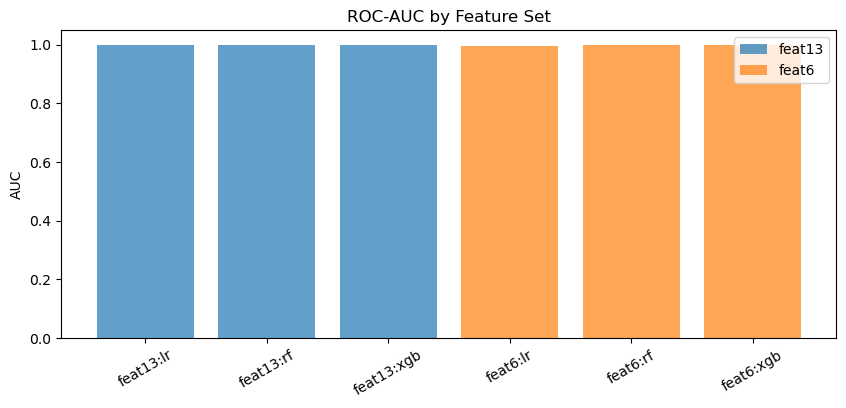

In [8]:
import matplotlib.pyplot as plt

plot_df = results_df.copy()

# AUC bar plot
fig, ax = plt.subplots(figsize=(10, 4))
for fs, sub in plot_df.groupby('feature_set'):
    ax.bar(
        [f"{fs}:{m}" for m in sub['model']],
        sub['roc_auc'],
        alpha=0.7,
        label=fs,
    )
ax.set_title('ROC-AUC by Feature Set')
ax.set_ylabel('AUC')
ax.tick_params(axis='x', rotation=30)
ax.legend()
plt.show()


## 8) Confusion Matrices

Plot confusion matrices for all models on the test set.

=== 13-Feature Set Confusion Matrices ===


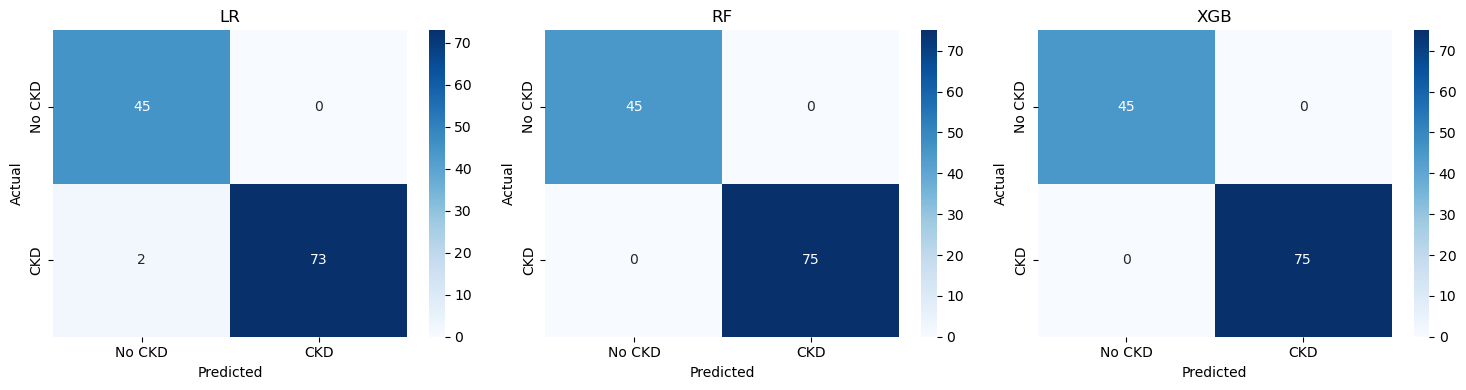


=== Confusion Matrices ===


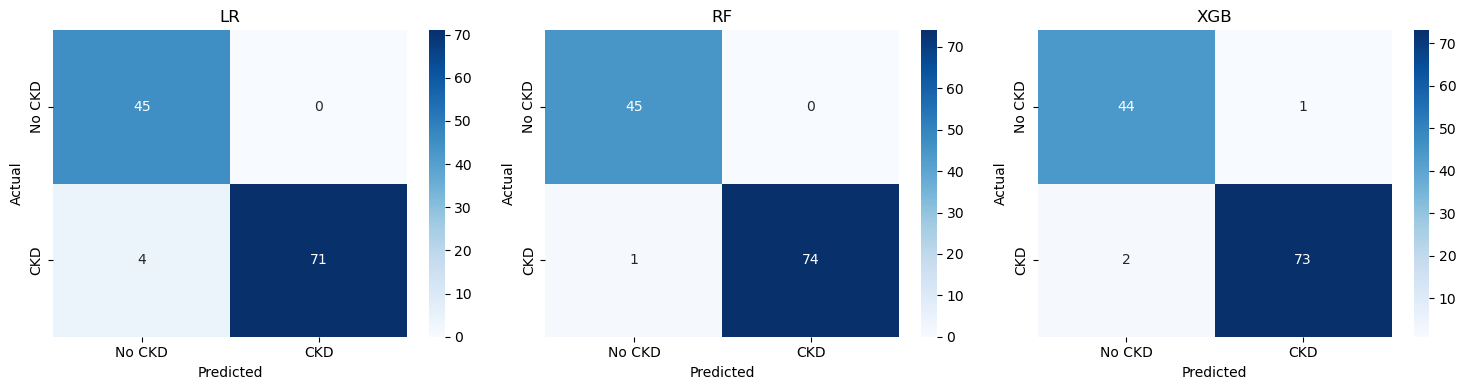

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrices(feature_set_name: str, feature_list: list[str]):
    """Plot confusion matrices for LR, RF, and XGB on test set."""
    X_tr = X_train_imp[feature_list].copy()
    X_te = X_test_imp[feature_list].copy()
    
    preprocessor = _build_preprocessor(feature_list, X_tr)
    
    models_to_plot = []
    
    # Logistic Regression
    lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=RANDOM_STATE)
    lr_pipe = Pipeline([('preprocess', preprocessor), ('model', lr)])
    lr_pipe.fit(X_tr, y_train)
    y_pred_lr = lr_pipe.predict(X_te)
    models_to_plot.append(('LR', y_pred_lr))
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=RANDOM_STATE)
    rf_pipe = Pipeline([('preprocess', preprocessor), ('model', rf)])
    rf_pipe.fit(X_tr, y_train)
    y_pred_rf = rf_pipe.predict(X_te)
    models_to_plot.append(('RF', y_pred_rf))
    
    # XGBoost
    try:
        from xgboost import XGBClassifier
        xgb = XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.05,
            random_state=RANDOM_STATE,
            eval_metric='logloss',
        )
        xgb_pipe = Pipeline([('preprocess', preprocessor), ('model', xgb)])
        xgb_pipe.fit(X_tr, y_train)
        y_pred_xgb = xgb_pipe.predict(X_te)
        models_to_plot.append(('XGB', y_pred_xgb))
    except Exception as e:
        print(f'XGBoost not available: {repr(e)}')
    
    # Plot confusion matrices
    n_models = len(models_to_plot)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))
    if n_models == 1:
        axes = [axes]
    
    for ax, (model_name, y_pred) in zip(axes, models_to_plot):
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            ax=ax,
            cbar=True,
            xticklabels=['No CKD', 'CKD'],
            yticklabels=['No CKD', 'CKD'],
        )
        ax.set_title(f'{model_name}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()


# Plot for 13-feature set
print('=== 13-Feature Set Confusion Matrices ===')
plot_confusion_matrices('13-feature', FEAT_13)

# Plot for 6-feature set
print('\n=== Confusion Matrices ===')
plot_confusion_matrices('6-feature', FEAT_6)

## 9) Save trained models (6-feature set)

Save the trained models with 6 features to the `models/` folder.

In [10]:
# Train and save models with 6-feature set
models_dir = PROJECT_ROOT / 'models'
ensure_dir(models_dir)

X_tr = X_train_imp[FEAT_6].copy()
X_te = X_test_imp[FEAT_6].copy()

preprocessor = _build_preprocessor(FEAT_6, X_tr)

# Train and save Logistic Regression
print('Training and saving LR model...')
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=RANDOM_STATE)
lr_pipe = Pipeline([('preprocess', preprocessor), ('model', lr)])
lr_pipe.fit(X_tr, y_train)
joblib.dump(lr_pipe, models_dir / 'lr.joblib')
print(f'Saved: {models_dir / "lr.joblib"}')

# Train and save Random Forest
print('Training and saving RF model...')
rf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=RANDOM_STATE)
rf_pipe = Pipeline([('preprocess', preprocessor), ('model', rf)])
rf_pipe.fit(X_tr, y_train)
joblib.dump(rf_pipe, models_dir / 'rf.joblib')
print(f'Saved: {models_dir / "rf.joblib"}')

# Train and save XGBoost
try:
    from xgboost import XGBClassifier
    print('Training and saving XGB model...')
    xgb = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
    )
    xgb_pipe = Pipeline([('preprocess', preprocessor), ('model', xgb)])
    xgb_pipe.fit(X_tr, y_train)
    joblib.dump(xgb_pipe, models_dir / 'xgb.joblib')
    print(f'Saved: {models_dir / "xgb.joblib"}')
except Exception as e:
    print(f'XGBoost not available: {repr(e)}')

print('\n✓ All models saved successfully!')

Training and saving LR model...
Saved: E:\docs\FYP\demo\CKD_Risk_Prediction\models\lr.joblib
Training and saving RF model...
Saved: E:\docs\FYP\demo\CKD_Risk_Prediction\models\rf.joblib
Training and saving XGB model...
Saved: E:\docs\FYP\demo\CKD_Risk_Prediction\models\xgb.joblib

✓ All models saved successfully!


## 10) Save metrics for visualization

Save test set metrics to `results/` folder for use with `python src/visualize.py`.

In [11]:
# Save metrics for visualization
results_dir = Path(RESULTS_DIR)
ensure_dir(results_dir)

# Save 13-feature set results
metrics_13 = results_df[results_df['feature_set'] == 'feat13'][['model', 'roc_auc', 'precision', 'recall', 'f1']].copy()
metrics_13_path = results_dir / 'metrics_feat13.csv'
metrics_13.to_csv(metrics_13_path, index=False)
print(f'Saved: {metrics_13_path}')

# Save 6-feature set results
metrics_6 = results_df[results_df['feature_set'] == 'feat6'][['model', 'roc_auc', 'precision', 'recall', 'f1']].copy()
metrics_6_path = results_dir / 'metrics_feat6.csv'
metrics_6.to_csv(metrics_6_path, index=False)
print(f'Saved: {metrics_6_path}')

# Save feature set metadata
feature_sets_meta = {
    'feat13': {
        'name': '13-feature set',
        'features': FEAT_13,
        'n_features': len(FEAT_13)
    },
    'feat6': {
        'name': '6-feature set',
        'features': FEAT_6,
        'n_features': len(FEAT_6)
    }
}
meta_path = results_dir / 'feature_sets.json'
save_json(feature_sets_meta, meta_path)
print(f'Saved: {meta_path}')

# Save full results table for reference
full_results_path = results_dir / 'feature_set_training_metrics.csv'
results_df.to_csv(full_results_path, index=False)
print(f'Saved: {full_results_path}')

print('\n✓ All metrics saved! You can now run: python src/visualize.py')

Saved: results\metrics_feat13.csv
Saved: results\metrics_feat6.csv
Saved: results\feature_sets.json
Saved: results\feature_set_training_metrics.csv

✓ All metrics saved! You can now run: python src/visualize.py
